In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, re, time
from os import listdir

import psutil
process = psutil.Process(os.getpid())
nbytes = process.memory_info().rss # bytes
print(f"Available memory: {psutil.virtual_memory().available / 1024 / 1024} Mb")
# print(f"Process memory: {nbytes} bytes ({nbytes / 1024 / 1024} Mb)") 

import numpy as np
import tensorflow as tf
from tensorflow import keras
print(f"Using Tensorflow v{tf.__version__}")

import matplotlib
import matplotlib.pyplot as plt 

# For managing relative imports from notebook
if '..' not in sys.path: sys.path.append('..')

import config.config as dfc
import deepfake.dfutillib as df

Available memory: 10722.3125 Mb
Using Tensorflow v2.0.0


In [2]:
def create_conv_network():
#{
    # Sort of a smaller, blended version of AlexNet and VGG-16

    # Layer #0: Input
    X_input = keras.layers.Input(shape=(1080, 1920, 3))
    
    # Layer #1-2: First set of convolutional layers
    X = keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(2,4))(X_input)
    X = keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(2,4))(X)
    X = keras.layers.MaxPooling2D()(X)
    
    # Layer #3-4: Second set of convolutional layers
    X = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1))(X)
    X = keras.layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1))(X)
    X = keras.layers.MaxPooling2D()(X)
    
    # Layer #5-6: Third set of convolutional layers
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1))(X)
    X = keras.layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1))(X)
    X = keras.layers.MaxPooling2D()(X)
    
    # Layer #7-9: Fully connected layers
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(512, activation = "relu")(X)
    X = keras.layers.Dense(512, activation = "relu")(X)
    X_output = keras.layers.Dense(1, activation = "relu")(X)
    
    model = keras.models.Model(inputs = X_input, outputs = X_output)
    model.summary()

    return model
#}

In [3]:
# Generate model and configure for training
model = create_conv_network()
opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-6)
early_stop = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1080, 1920, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, 535, 478, 32)      11648     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 263, 117, 32)      123936    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 131, 58, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 129, 56, 64)       18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 54, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 27, 64)        0     

In [4]:
splitter = df.DataSplitter(validation_split=0.2, data_subset=0.2)
train_loader = df.lazy_load_partition(splitter)
valid_loader = df.lazy_load_partition(splitter, validation=True)

In [5]:
initial = time.time()
history = model.fit_generator(
    generator=train_loader, steps_per_epoch=len(splitter.train_split),
    validation_data=valid_loader, validation_steps=len(splitter.valid_split),
    callbacks=early_stop, epochs=5)

print(f"Total training time: {time.time()-initial:.3f}")

Epoch 1/5
213/213 [==============================] - 9210s 43s/step - loss: 245703859.6669 - accuracy: 0.0610 - val_loss: 3.2163 - val_accuracy: 0.0000e+00
Epoch 2/5
213/213 [==============================] - 9175s 43s/step - loss: 3.2557 - accuracy: 0.0798 - val_loss: 3.2834 - val_accuracy: 0.0000e+00
Epoch 3/5
213/213 [==============================] - 9164s 43s/step - loss: 2.8861 - accuracy: 0.1362 - val_loss: 3.4984 - val_accuracy: 0.1887
Epoch 4/5
213/213 [==============================] - 9184s 43s/step - loss: 3.1613 - accuracy: 0.0516 - val_loss: 2.5411 - val_accuracy: 0.1887
Epoch 5/5
213/213 [==============================] - 9256s 43s/step - loss: 3.2701 - accuracy: 0.0000e+00 - val_loss: 2.9051 - val_accuracy: 0.1887
Total training time: 45988.241


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


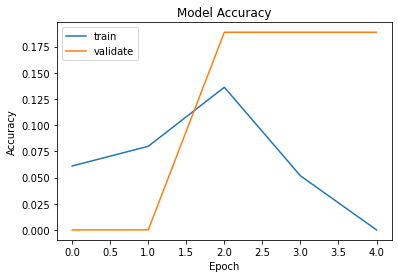

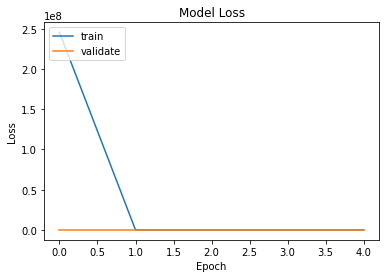

In [6]:
print(history.history.keys())

# Plot with respect to accuracy
plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')

# Plot with respect to loss
plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validate'], loc='upper left')